<a href="https://colab.research.google.com/github/yuvalofek/Deep_Learning/blob/master/DeepLearningAssignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ECE472, Deep Learning – Assignment 4**

Submit by Oct. 1, 10pm

tldr: Classify cifar10. Acheive performance similar to the state of the art. Classify cifar100. Achieve a top-5 accuracy of 80%.

In [ ]:
import numpy as np
import pandas as pd
import numpy.random as npr
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Add, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling2D, Input, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import TopKCategoricalAccuracy 

import tarfile
import os
import sys
import pickle
from urllib.request import urlretrieve

In [ ]:
#Links I looked at and might not have mentioned elsewhere:
'''
https://github.com/ostapstephan/DeepLearning/blob/master/hw4curro/CIFAR10Res.py
https://github.com/Minhtyyufa/Deep_Learning/blob/master/hw_4/hw_4.py
https://github.com/keras-team/keras/blob/
  1a3ee8441933fc007be6b2beb47af67998d50737/examples/cifar10_resnet.py#L140
https://www.reddit.com/r/MachineLearning/comments/7806n6/
  d_why_arent_inceptionstyle_networks_successful_on/
https://analyticsindiamag.com/why-resnets-are-a-major-breakthrough-in-image-processing/
  #:~:text=ResNets%20are%20being%20implemented%20in,negate%20the%20vanishing%20gradient%20problem.
https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec
https://github.com/facebookarchive/fb.resnet.torch/blob/master/models/resnet.lua
https://towardsdatascience.com/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5
https://github.com/hendrycks/init/blob/master/cifar100.py
'''

'\nhttps://github.com/ostapstephan/DeepLearning/blob/master/hw4curro/CIFAR10Res.py\nhttps://github.com/Minhtyyufa/Deep_Learning/blob/master/hw_4/hw_4.py\nhttps://github.com/keras-team/keras/blob/\n  1a3ee8441933fc007be6b2beb47af67998d50737/examples/cifar10_resnet.py#L140\nhttps://www.reddit.com/r/MachineLearning/comments/7806n6/\n  d_why_arent_inceptionstyle_networks_successful_on/\nhttps://analyticsindiamag.com/why-resnets-are-a-major-breakthrough-in-image-processing/\n  #:~:text=ResNets%20are%20being%20implemented%20in,negate%20the%20vanishing%20gradient%20problem.\nhttps://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec\nhttps://github.com/facebookarchive/fb.resnet.torch/blob/master/models/resnet.lua\nhttps://towardsdatascience.com/mobilenetv2-inverted-residuals-and-linear-bottlenecks-8a4362f4ffd5\nhttps://github.com/hendrycks/init/blob/master/cifar100.py\n'

In [ ]:
im_size  = 32
im_channels = 3
train_num = 50_000
test_num = 10_000
SEED = 25

def cifar10(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing CIFAR-10. Default is
            /home/USER/data/cifar10 or C:\Users\USER\data\cifar10.
            Create if nonexistant. Download CIFAR-10 if missing.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values,
            with the order (red -> blue -> green). Columns of labels are a
            onehot encoding of the correct class.
    
    
    Found function at:
    https://mattpetersen.github.io/load-cifar10-with-numpy
    """
    url = 'https://www.cs.toronto.edu/~kriz/'
    tar = 'cifar-10-binary.tar.gz'
    files = ['cifar-10-batches-bin/data_batch_1.bin',
             'cifar-10-batches-bin/data_batch_2.bin',
             'cifar-10-batches-bin/data_batch_3.bin',
             'cifar-10-batches-bin/data_batch_4.bin',
             'cifar-10-batches-bin/data_batch_5.bin',
             'cifar-10-batches-bin/test_batch.bin']

    if path is None:
        path = os.path.join(os.path.expanduser('~'), 'data', 'cifar10')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download tarfile if missing
    if tar not in os.listdir(path):
        urlretrieve(''.join((url, tar)), os.path.join(path, tar))
        print("Downloaded %s to %s" % (tar, path))

    # Load data from tarfile
    with tarfile.open(os.path.join(path, tar)) as tar_object:
        # Each file contains 10,000 color images and 10,000 labels
        fsize = 10000 * (32 * 32 * 3) + 10000

        # There are 6 files (5 train and 1 test)
        buffr = np.zeros(fsize * 6, dtype='uint8')

        # Get members of tar corresponding to data files
        # -- The tar contains README's and other extraneous stuff
        members = [file for file in tar_object if file.name in files]

        # Sort those members by name
        # -- Ensures we load train data in the proper order
        # -- Ensures that test data is the last file in the list
        members.sort(key=lambda member: member.name)

        # Extract data from members
        for i, member in enumerate(members):
            # Get member as a file object
            f = tar_object.extractfile(member)
            # Read bytes from that file object into buffr
            buffr[i * fsize:(i + 1) * fsize] = np.frombuffer(f.read(), 'B')

    # Parse data from buffer
    # -- Examples are in chunks of 3,073 bytes
    # -- First byte of each chunk is the label
    # -- Next 32 * 32 * 3 = 3,072 bytes are its corresponding image

    # Labels are the first byte of every chunk
    labels = buffr[::3073]

    # Pixels are everything remaining after we delete the labels
    pixels = np.delete(buffr, np.arange(0, buffr.size, 3073))
    images = pixels.reshape(-1, 3072).astype('float32') / 255

    # Split into train and test
    train_images, test_images = images[:50000], images[50000:]
    train_labels, test_labels = labels[:50000], labels[50000:]

    return train_images, train_labels, test_images, test_labels

In [ ]:
train_images, train_labels, test_images, test_labels = cifar10()

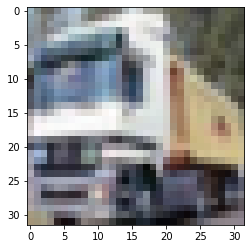

In [ ]:
plt.imshow(np.transpose(train_images.reshape(-1, 3,32,32), (0, 2, 3, 1))[1])

In [ ]:
num_classes  = 10

def shuffle(X, y, seed = SEED):
  npr.seed(seed)
  num_shuffle = X.shape[0]
  idxes = npr.permutation(num_shuffle)
  return X[idxes], y[idxes]

def format_imgs(X,y, num_classes = num_classes):
  X_, y_ = shuffle(X, y)
  X_out = np.transpose(X_.reshape(-1,3,32,32), (0, 2, 3, 1))/255.
  Y_out = tf.keras.utils.to_categorical(y_, num_classes)
  return X_out, Y_out

train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)
X_train, y_train = format_imgs(train_images, train_labels)
X_test, y_test = format_imgs(test_images, test_labels)



#normalize 
mu_X = np.mean(X_train)
sig_X = np.std(X_train)

X_train = (X_train-mu_X)/sig_X
X_test = (X_test-mu_X)/sig_X

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.05, 
                                                  random_state = SEED)

# Training generator
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    horizontal_flip = True,
)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=128,
)     

#Validation generator
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(
    X_val,
    y_val,
)

#Test generator
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    X_test,
    y_test,
)

In [ ]:
WEIGHT_DECAY = 7e-3

def res_layer(inputs,
              num_filters,
              kernel_size=3,
              activation='elu'):
  x = inputs
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  y = Conv2D(num_filters,
             kernel_size=kernel_size,
             padding='same',
             kernel_initializer='he_normal',
             kernel_regularizer=l2(WEIGHT_DECAY))(x)
  x = BatchNormalization()(y)
  x = Activation(activation)(x)
  x = Conv2D(num_filters,
             kernel_size=kernel_size,
             padding='same',
             kernel_initializer='he_normal',
             kernel_regularizer=l2(WEIGHT_DECAY))(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = Conv2D(num_filters,
             kernel_size=kernel_size,
             padding='same',
             kernel_initializer='he_normal',
             kernel_regularizer=l2(WEIGHT_DECAY))(x)
  return Add()([y, x])

In [ ]:
num_classes=10
num_filters = 16

#Create Model
inputs = Input(shape=X_train.shape[1:])
y = res_layer(inputs=inputs, num_filters=num_filters)	
for i in range(2):
  y = MaxPooling2D(pool_size=2,strides=2)(y)
  num_filters*=2
  y = res_layer(inputs=y, num_filters=num_filters)	
y = Activation("elu")(y)
y = MaxPooling2D(pool_size=8)(y)
y = Flatten()(y)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal', 
                activity_regularizer=l2(WEIGHT_DECAY))(y)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

#summary
model.summary()

# Compile Model. 
model.compile(loss = "categorical_crossentropy", 
              optimizer = 'adam', 
              metrics = ['acc'])

#Callbacks
def lr_schedule(epoch): 
	lr = 1e-3
	if epoch > 90:
		lr *= 1e-3
	elif epoch > 70:
		lr *= 1e-2
	elif epoch > 40:
		lr *= 1e-1
	elif epoch > 20:
		lr *= 5e-1
	print('Learning rate: ', lr)
	return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks = [lr_scheduler]

# Train the Model
history = model.fit(
    train_generator,
    batch_size = 128,
    epochs = 110,
    verbose = 1,
    validation_data = val_generator, 
    callbacks = callbacks
)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 32, 32, 3)    12          input_5[0][0]                    
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 32, 32, 3)    0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 32, 32, 16)   448         activation_31[0][0]              
_______________________________________________________________________________________

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


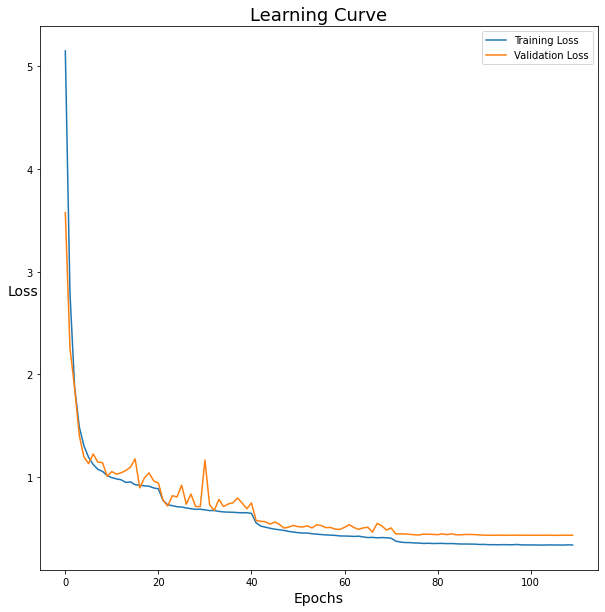

In [ ]:
# Learning Curve
plt.figure(figsize = (10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs', fontsize = 14)
h = plt.ylabel('Loss',fontsize = 14)
h.set_rotation(0)
plt.title('Learning Curve', fontsize = 18)
plt.legend(['Training Loss', 'Validation Loss'])
plt.savefig('LearningCurveCifar10.eps', format='eps')
plt.show()

In [ ]:
#Evaluate on test set
results = model.evaluate(test_generator, verbose=0)
print('Test Accuracy:', results[1])

Test Accuracy: 0.8859999775886536


Cifar100

In [ ]:
def download_dataset(path, source='https://www.cs.toronto.edu/~kriz/'
                                  'cifar-100-python.tar.gz'):
    """
    Downloads and extracts the dataset, if needed.
    https://github.com/vahidk/TensorflowFramework/blob/master/dataset/cifar100.py
    """
    files = ['train', 'test']
    for fn in files:
        if not os.path.exists(os.path.join(path, "cifar-100-python", fn)):
            break  # at least one file is missing
    else:
        return  # dataset is already complete

    print("Downloading and extracting %s into %s..." % (source, path))
    
    if sys.version_info[0] == 2:
        from urllib import urlopen
    else:
        from urllib.request import urlopen
    import tarfile
    if not os.path.exists(path):
        os.makedirs(path)
    u = urlopen(source)
    with tarfile.open(fileobj=u, mode='r|gz') as f:
        f.extractall(path=path)
    u.close()

def load_dataset(path = None):
    if path is None:
        path = os.path.join(os.path.expanduser('~'), 'data', 'cifar100')
    
    download_dataset(path)

    # training data
    data = pickle.load(open(os.path.join(path, "cifar-100-python", "train"),
                            'rb'), encoding='latin1')
    X_train = data['data']
    y_train = np.asarray(data['fine_labels'], np.int8)

    # test data
    data = pickle.load(open(os.path.join(path, 'cifar-100-python', 'test'),
                            'rb'), encoding='latin1')
    X_test = data['data']
    y_test = np.asarray(data['fine_labels'], np.int8)

    return X_train, y_train, X_test, y_test

In [ ]:
train_images100, train_labels100, test_images100, test_labels100 = load_dataset()

0

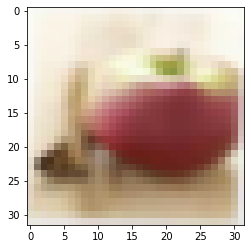

In [ ]:
plt.imshow(np.transpose(train_images100.reshape(-1, 3,32,32), (0, 2, 3, 1))[2])
train_labels100[2]

In [ ]:
num_classes=100

train_images100, train_labels100 = shuffle(train_images100, train_labels100)
test_images100, test_labels100 = shuffle(test_images100, test_labels100)
X_train100, y_train100 = format_imgs(train_images100, train_labels100, num_classes)
X_test100, y_test100 = format_imgs(test_images100, test_labels100, num_classes)


#normalize 
mu_X100 = np.mean(X_train100)
sig_X100 = np.std(X_train100)

X_train100 = (X_train100-mu_X100)/sig_X100
X_test100 = (X_test100-mu_X100)/sig_X100

X_train100, X_val100, y_train100, y_val100 = train_test_split(X_train100,
                                                              y_train100,
                                                              test_size = 0.05, 
                                                              random_state = SEED)
# Training generator
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    horizontal_flip = True,
)

train_generator100 = train_datagen.flow(
    X_train100,
    y_train100,
    batch_size=128,
)     

#Validation generator
val_datagen = ImageDataGenerator()
val_generator100 = val_datagen.flow(
    X_val100,
    y_val100,
)

#Test generator
test_datagen = ImageDataGenerator()
test_generator100 = test_datagen.flow(
    X_test100,
    y_test100,
)

In [ ]:
num_filters = 16

#Create Model
inputs = Input(shape=X_train100.shape[1:])
y = res_layer(inputs=inputs, num_filters=num_filters)	
for i in range(2):
  y = MaxPooling2D(pool_size=2,strides=2)(y)
  num_filters*=2
  y = res_layer(inputs=y, num_filters=num_filters)	
y = Activation("elu")(y)
y = MaxPooling2D(pool_size=8)(y)
y = Flatten()(y)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal', 
                activity_regularizer=l2(WEIGHT_DECAY))(y)
model2 = tf.keras.models.Model(inputs=inputs, outputs=outputs)

#summary
model2.summary()

# Compile Model. 
model2.compile(loss = "categorical_crossentropy", 
              optimizer = 'adam', 
              metrics = [TopKCategoricalAccuracy(k=5)])

#Callbacks
def lr_schedule(epoch): 
	lr = 1e-3
	if epoch > 90:
		lr *= 1e-3
	elif epoch > 70:
		lr *= 1e-2
	elif epoch > 40:
		lr *= 1e-1
	elif epoch > 20:
		lr *= 5e-1
	print('Learning rate: ', lr)
	return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
callbacks = [lr_scheduler]

# Train the Model
history2 = model2.fit(
    train_generator100,
    batch_size = 128,
    epochs = 100,
    verbose = 1,
    validation_data = val_generator100, 
    callbacks = callbacks
)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 32, 32, 3)    12          input_2[0][0]                    
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 32, 32, 3)    0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 16)   448         activation_10[0][0]              
_______________________________________________________________________________________

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


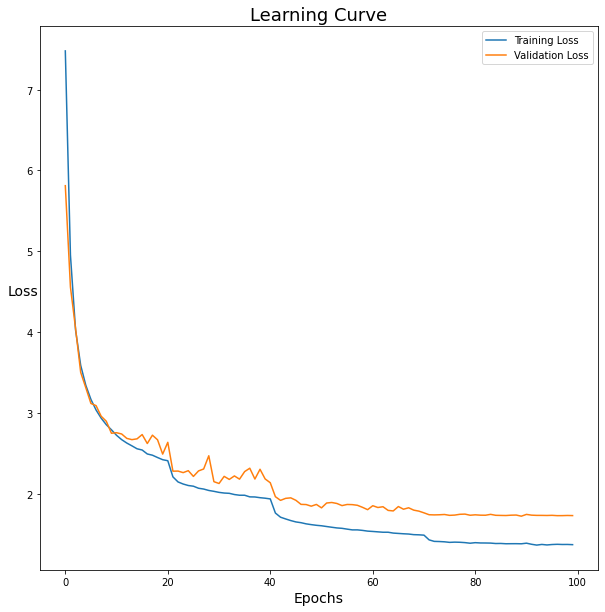

In [ ]:
# Learning Curve
plt.figure(figsize = (10,10))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.xlabel('Epochs', fontsize = 14)
h = plt.ylabel('Loss',fontsize = 14)
h.set_rotation(0)
plt.title('Learning Curve', fontsize = 18)
plt.legend(['Training Loss', 'Validation Loss'])
plt.savefig('LearningCurveCifar100.eps', format='eps')
plt.show()

In [ ]:
#Evaluate on test set
results = model2.evaluate(test_generator100, verbose=0)
print('Test Top 5 Accuracy:', results[1])

Test Top 5 Accuracy: 0.8551999926567078
